In [1]:
import os
import torch
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.utils.data import DataLoader
from modules.lifter_2d_3d.dataset.groundtruth_keypoint_dataset import GroundTruthKeypointDataset
from modules.lifter_2d_3d.model.linear_model.lit_linear_model import LitSimpleBaselineLinear
from modules.utils.visualization import (
    plot_samples
)
from IPython.display import display
from pathlib import Path
pl.seed_everything(1234)

# ------------
# dataset path
# ------------
dataset_root_path = Path('/root/synthetic_cabin_1m/syntheticcabin_1mil/processed_syntheticCabin_1m/A_Pillar_Codriver/')
keypoint_2d_path = dataset_root_path / 'annotations'
keypoint_3d_path = dataset_root_path / 'annotations'
# ------------
# model
# ------------
image_width = 1280
image_height = 1024
batch_size = 64
max_epoch = 200
val_check_period = 5
early_stopping_patience = 5
lit_model = LitSimpleBaselineLinear(exclude_ankle=True, exclude_knee=True)
# ------------
# saved model path
# ------------
saved_model_path = './saved_lifter_2d_3d_model/linear_model/synthetic_cabin_ir_1m/A_Pillar_Codriver/gt_2d/'


train_dataset = GroundTruthKeypointDataset(
    annotation_file=(keypoint_3d_path / 'person_keypoints_train.json').as_posix(),
    image_width=image_width,
    image_height=image_height,
    exclude_ankle=True,
    exclude_knee=True
)
val_dataset = GroundTruthKeypointDataset(
    annotation_file=(keypoint_3d_path / 'person_keypoints_val.json').as_posix(),
    image_width=image_width,
    image_height=image_height,
    exclude_ankle=True,
    exclude_knee=True
)
test_dataset = GroundTruthKeypointDataset(
    annotation_file=(keypoint_3d_path / 'person_keypoints_test.json').as_posix(),
    image_width=image_width,
    image_height=image_height,
    exclude_ankle=True,
    exclude_knee=True
)

print(
    'train_dataset', len(train_dataset),
    'val_dataset', len(val_dataset),
    'test_dataset', len(test_dataset)
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True, num_workers=24)
val_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True, num_workers=24)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=24)

model_checkpoint = ModelCheckpoint(monitor='val_loss',mode='min', save_top_k=1)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=early_stopping_patience)


if not os.path.exists(saved_model_path):
    os.makedirs(saved_model_path)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
trainer = pl.Trainer(
    # max_steps=10,
    max_epochs=max_epoch,
    callbacks=[model_checkpoint, early_stopping],
    accelerator=device,
    check_val_every_n_epoch=val_check_period,
    default_root_dir=saved_model_path,
    gradient_clip_val=1.0
)
trainer.fit(lit_model, train_loader, val_loader)

Global seed set to 1234
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


train_dataset 75000 val_dataset 37500 test_dataset 30349


Missing logger folder: saved_lifter_2d_3d_model/synthetic_cabin_ir_1m/A_Pillar_Codriver/ground_truth_2d_keypoints/linear_model/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params
----------------------------------------
0 | model | BaselineModel | 4.3 M 
----------------------------------------
4.3 M     Trainable params
0         Non-trainable params
4.3 M     Total params
17.105    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

check #0
val MPJPE from: 128 samples : 5545.243740081787


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

check #1
training loss from 5855 batches: 259.7663705963339
val MPJPE from: 37440 samples : 96.34823352098465


Validation: 0it [00:00, ?it/s]

check #2
training loss from 5855 batches: 125.40635280152043
val MPJPE from: 37440 samples : 76.48468762636185


Validation: 0it [00:00, ?it/s]

check #3
training loss from 5855 batches: 115.22922327918542
val MPJPE from: 37440 samples : 72.11116701364517


Validation: 0it [00:00, ?it/s]

check #4
training loss from 5855 batches: 108.19014714478837
val MPJPE from: 37440 samples : 69.21065598726273


Validation: 0it [00:00, ?it/s]

check #5
training loss from 5855 batches: 103.7171442141195
val MPJPE from: 37440 samples : 66.0184696316719


Validation: 0it [00:00, ?it/s]

check #6
training loss from 5855 batches: 100.66272022884998
val MPJPE from: 37440 samples : 66.64733588695526


Validation: 0it [00:00, ?it/s]

check #7
training loss from 5855 batches: 98.46155345439911
val MPJPE from: 37440 samples : 66.29959493875504


Validation: 0it [00:00, ?it/s]

check #8
training loss from 5855 batches: 96.74086450868748
val MPJPE from: 37440 samples : 64.41471725702286


Validation: 0it [00:00, ?it/s]

check #9
training loss from 5855 batches: 95.44797962822535
val MPJPE from: 37440 samples : 64.57559019327164


Validation: 0it [00:00, ?it/s]

check #10
training loss from 5855 batches: 94.52560774975613
val MPJPE from: 37440 samples : 63.05394321680069


Validation: 0it [00:00, ?it/s]

check #11
training loss from 5855 batches: 93.59359147455018
val MPJPE from: 37440 samples : 62.799304723739624


Validation: 0it [00:00, ?it/s]

check #12
training loss from 5855 batches: 92.94515029804815
val MPJPE from: 37440 samples : 61.899833381175995


Validation: 0it [00:00, ?it/s]

check #13
training loss from 5855 batches: 92.38184949559701
val MPJPE from: 37440 samples : 62.11647018790245


Validation: 0it [00:00, ?it/s]

check #14
training loss from 5855 batches: 92.04769412311705
val MPJPE from: 37440 samples : 62.46182695031166


Validation: 0it [00:00, ?it/s]

check #15
training loss from 5855 batches: 91.63640228018203
val MPJPE from: 37440 samples : 62.476564198732376


Validation: 0it [00:00, ?it/s]

check #16
training loss from 5855 batches: 91.38919567318679
val MPJPE from: 37440 samples : 62.707044184207916


Validation: 0it [00:00, ?it/s]

check #17
training loss from 5855 batches: 91.10213107120065
val MPJPE from: 37440 samples : 62.30713427066803


In [2]:
with open(f'{saved_model_path}/best_model_path.txt', 'w') as f:
    f.writelines(model_checkpoint.best_model_path)
best_checkpoint_path = model_checkpoint.best_model_path
trainer.test(ckpt_path=best_checkpoint_path, dataloaders=test_loader)

Restoring states from the checkpoint path at saved_lifter_2d_3d_model/synthetic_cabin_ir_1m/A_Pillar_Codriver/ground_truth_2d_keypoints/linear_model/lightning_logs/version_0/checkpoints/epoch=59-step=70260.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at saved_lifter_2d_3d_model/synthetic_cabin_ir_1m/A_Pillar_Codriver/ground_truth_2d_keypoints/linear_model/lightning_logs/version_0/checkpoints/epoch=59-step=70260.ckpt


Testing: 0it [00:00, ?it/s]

MPJPE: 58.92569637016972
PJPE
                      PJPE
nose             47.742348
left_eye         46.540898
right_eye        46.896085
left_ear         47.803436
right_ear        50.714947
left_shoulder    49.299136
right_shoulder   41.094556
left_elbow       78.524417
right_elbow      61.874635
left_wrist      103.843476
right_wrist      90.581861
left_hip         52.113850
right_hip        49.004407
activities_mpjpe:
{}
test mpjpe: 58.92569637016972


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           mpjpe           │     58.92569637016972     │
└───────────────────────────┴───────────────────────────┘

[{'mpjpe': 58.92569637016972}]

In [3]:
trainer.model.test_history[0]['pjpe']

,PJPE
nose,47.742348
left_eye,46.540898
right_eye,46.896085
left_ear,47.803436
right_ear,50.714947
left_shoulder,49.299136
right_shoulder,41.094556
left_elbow,78.524417
right_elbow,61.874635
left_wrist,103.843476


In [4]:
trainer.model.test_history[0]['mpjpe']

58.92569637016972

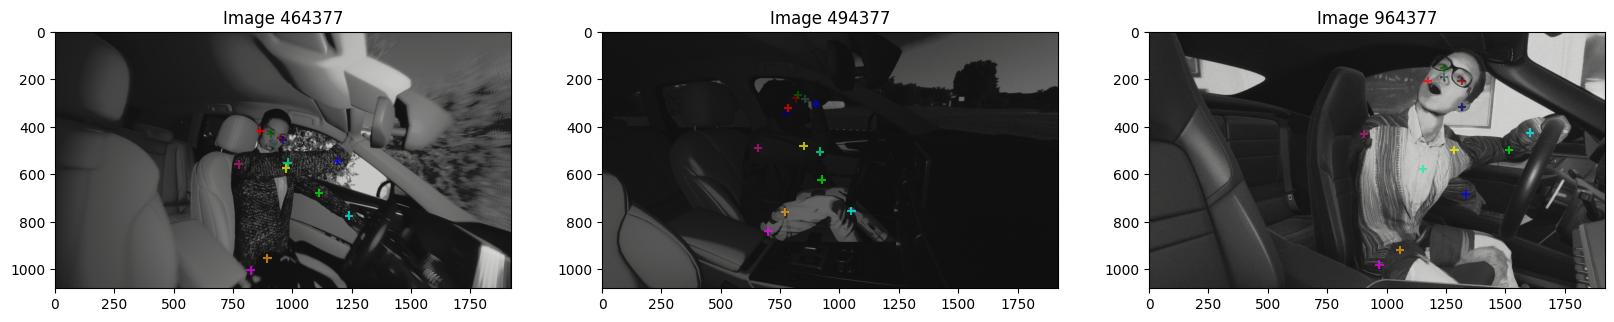

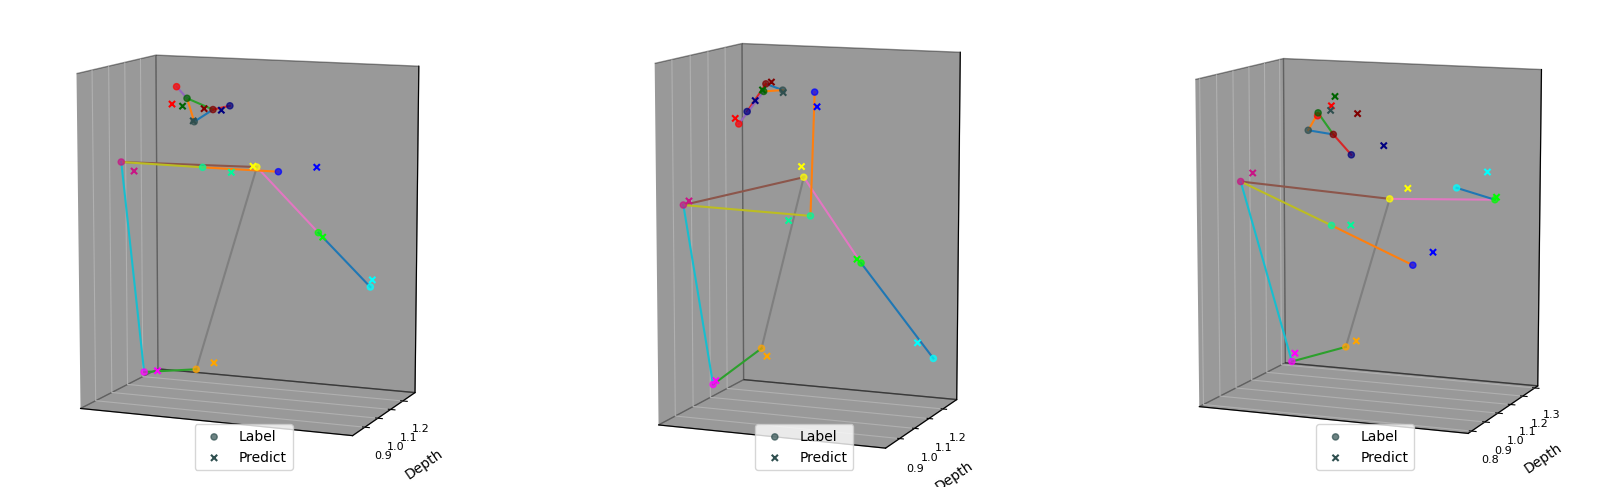

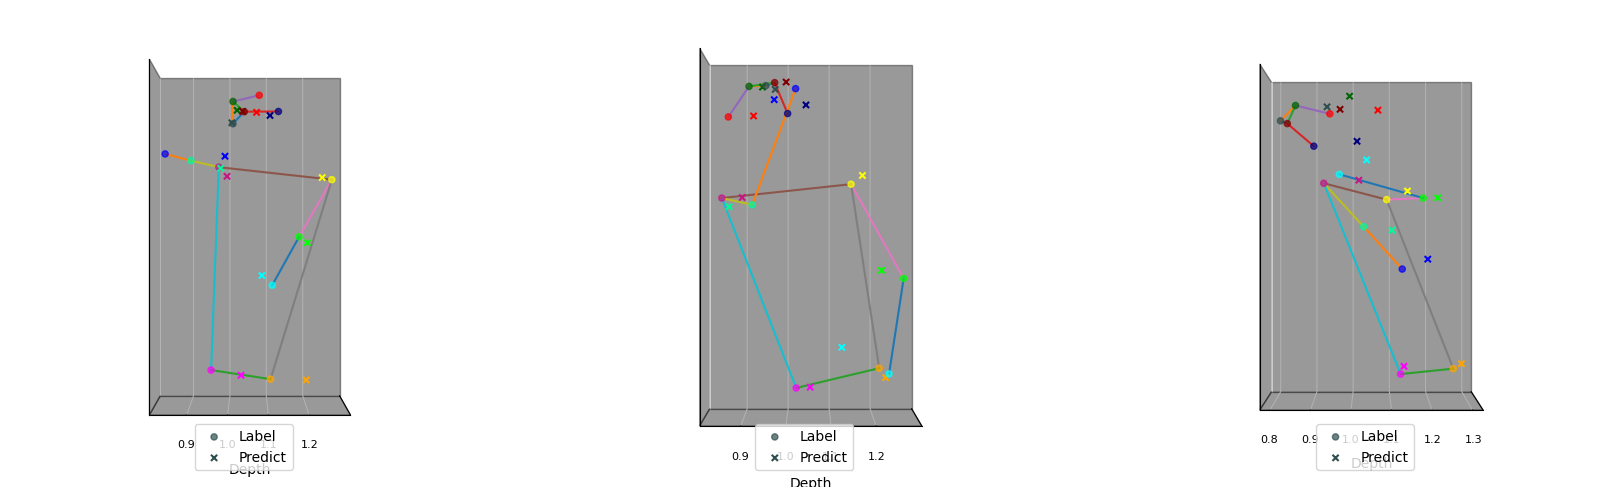

In [6]:
plot_samples(
    dataset_root_path,
    trainer.model,
    test_loader,
    'test',
    img_figsize=(20, 10),
    img_width=image_width,
    img_height=image_height,
    plot_figsize=(20.5, 10),
    sample_idices=[5000, 10000, 30000]
)